In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
from sklearn.metrics import mean_absolute_error

In [ ]:
# Read csv - Employment Characteristics (14100287)
# df = pd.read_csv('data/14100287.csv', low_memory=False)  # Use with a full dataset
df = pd.read_csv('data/14100287_sample.csv', low_memory=False)

In [95]:
df.head()

,REF_DATE,GEO,DGUID,Labour force characteristics,Gender,Age group,Statistics,Data type,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,1976-01,Canada,2021A000011124,Population,Total - Gender,15 years and over,Estimate,Seasonally adjusted,Persons in thousands,428,thousands,3,v2062809,1.1.1.1.1.1,16852.4,NaN,NaN,NaN,1
1,1976-01,Canada,2021A000011124,Population,Total - Gender,15 years and over,Estimate,Unadjusted,Persons in thousands,428,thousands,3,v2064888,1.1.1.1.1.2,16852.4,NaN,NaN,NaN,1
2,1976-01,Canada,2021A000011124,Population,Total - Gender,15 to 64 years,Estimate,Seasonally adjusted,Persons in thousands,428,thousands,3,v21580997,1.1.1.8.1.1,15015.9,NaN,NaN,NaN,1
3,1976-01,Canada,2021A000011124,Population,Total - Gender,15 to 64 years,Estimate,Unadjusted,Persons in thousands,428,thousands,3,v21580998,1.1.1.8.1.2,15015.9,NaN,NaN,NaN,1
4,1976-01,Canada,2021A000011124,Population,Total - Gender,15 to 24 years,Estimate,Seasonally adjusted,Persons in thousands,428,thousands,3,v2062836,1.1.1.2.1.1,4509.9,NaN,NaN,NaN,1


In [96]:
# Only include the following rows - Employment Characteristics
row2include = (
    (df['GEO'] == 'Canada') &
    (df['Gender'] == 'Total - Gender') &
    (df['Statistics'] == 'Estimate') &
    (df['Data type'] == 'Seasonally adjusted') &
    (df['Labour force characteristics'].isin([
        'Population',
        'Full-time employment',
        'Part-time employment', 
        'Unemployment rate', 
        'Participation rate']))
)

# Filtering the rows
df = df[row2include]

# df_cleaned = df[df['Age group'] == '15 to 24 years']
df_15to24 = df[df['Age group'] == '15 to 24 years']
df_25up = df[df['Age group'] == '25 years and over']

# Drop unused columns - Employment Characteristics
col2drop = ['GEO', 'DGUID', 'Gender', 'Age group', 'Statistics', 'Data type', 'UOM', 'UOM_ID', 'SCALAR_FACTOR', 'SCALAR_ID', 'VECTOR', 'COORDINATE', 'STATUS', 'SYMBOL', 'TERMINATED', 'DECIMALS']

df_15to24_cln = df_15to24.drop(col2drop, axis=1).copy()
df_25up_cln = df_25up.drop(col2drop, axis=1).copy()

In [97]:
# Pivot the dfs

# Pivot Labour force characteristics into features
def create_col(df):
    # pivot wider: rows = date, columns = duration, values = VALUE
    df_wide = df.pivot_table(
        index="REF_DATE", 
        columns= "Labour force characteristics", 
        values="VALUE"
    )
    
    # Tidy up
    df_wide = df_wide.sort_index().reset_index()
    
    # Set date index
    df_wide['REF_DATE'] = pd.to_datetime(df_wide['REF_DATE'], format='%Y-%m')
    df_wide.set_index('REF_DATE', inplace=True)
    
    return df_wide

# Calling the method
df_15to24_pivot = create_col(df_15to24_cln)
df_25up_pivot = create_col(df_25up_cln)

# Inspect
print(df_15to24_pivot.info())
print(df_25up_pivot.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 596 entries, 1976-01-01 to 2025-08-01
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Full-time employment  596 non-null    float64
 1   Part-time employment  596 non-null    float64
 2   Participation rate    596 non-null    float64
 3   Population            596 non-null    float64
 4   Unemployment rate     596 non-null    float64
dtypes: float64(5)
memory usage: 27.9 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 596 entries, 1976-01-01 to 2025-08-01
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Full-time employment  596 non-null    float64
 1   Part-time employment  596 non-null    float64
 2   Participation rate    596 non-null    float64
 3   Population            596 non-null    float64
 4   Unemployment rate     596 non-null    fl

# Exploratory Data Analysis

This section explores key correlates in the cleaned dataset.

1) Participation Rate vs Unemployment Rate

2) Emplyment Trend (Full-time vs Part-time)

## EDA 1) Participation Rate vs Unemployment Rate

C:\Users\elvie\AppData\Local\Temp\ipykernel_57688\1414473280.py:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


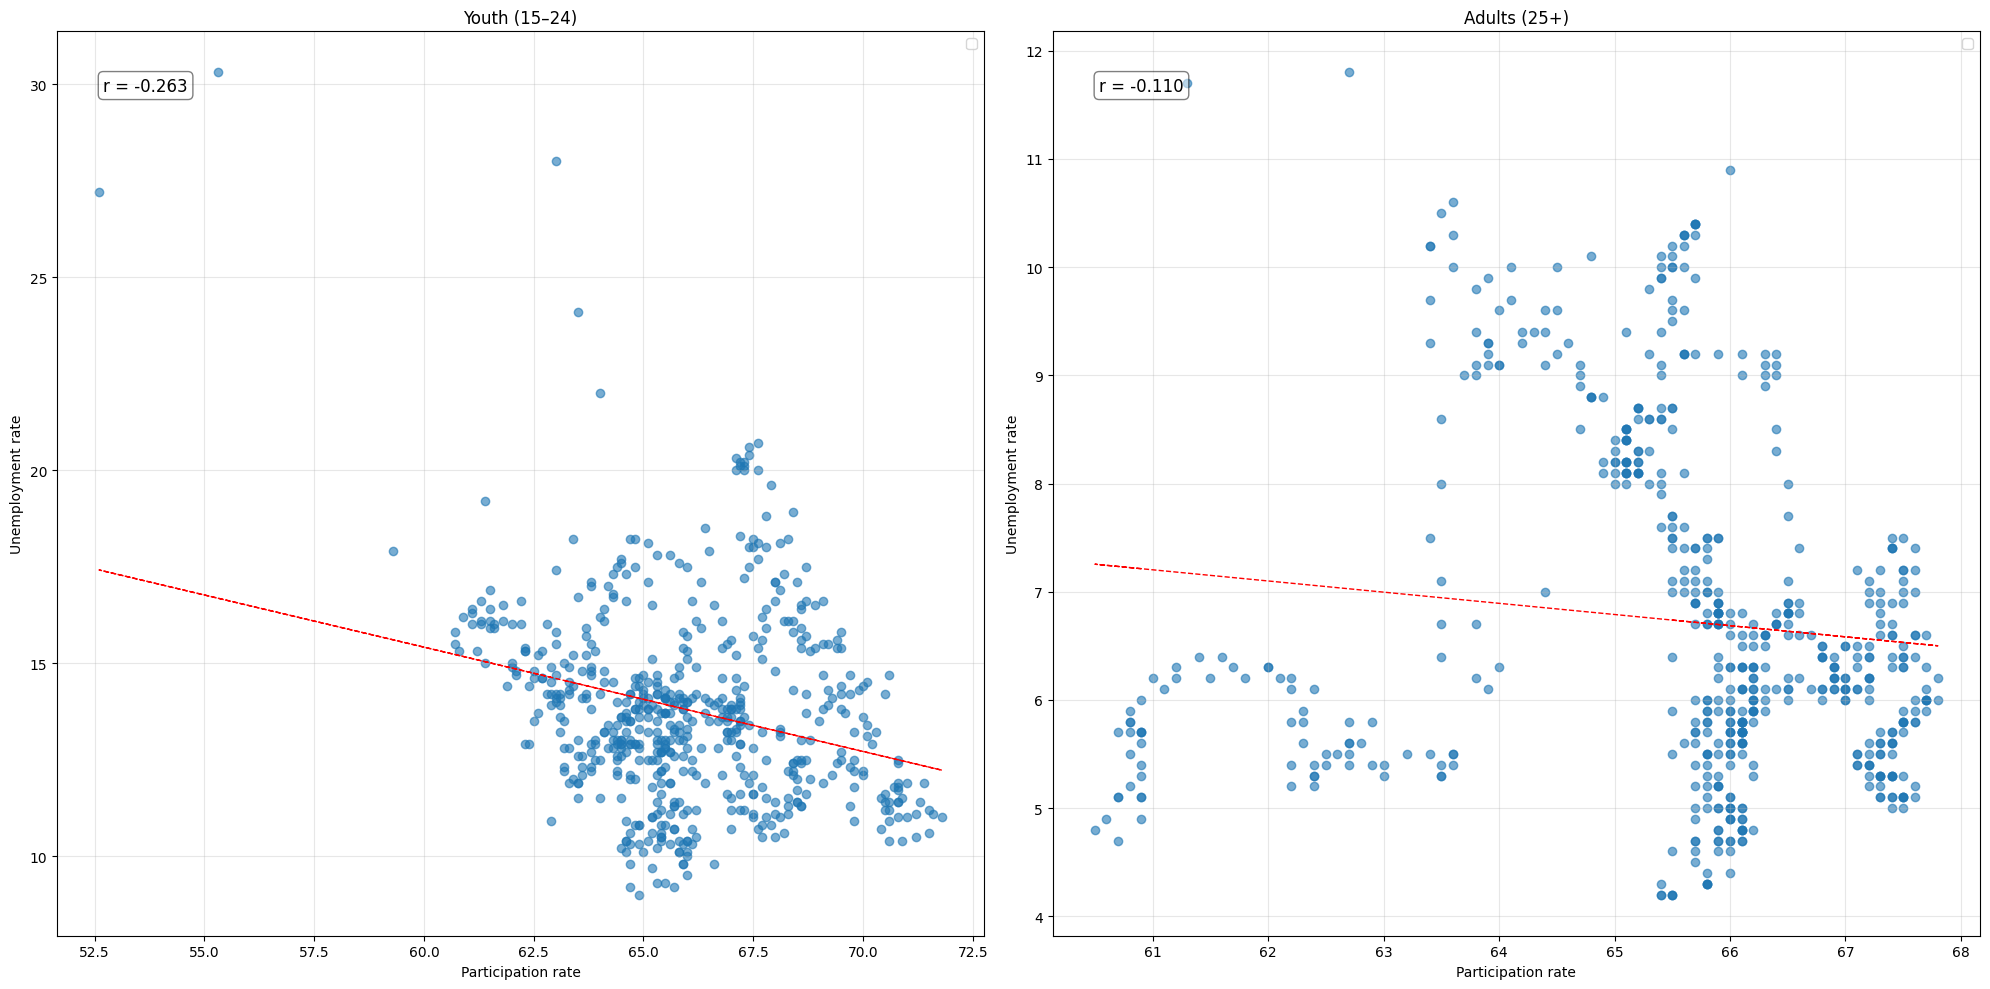

In [98]:
# Plotting participation rate against unemployment rate
def plot_correlation_subplots(df1, df2, x_col, y_col, titles=None):

    fig, axes = plt.subplots(1, 2, figsize=(20, 10))

    for i, df in enumerate([df1, df2]):
        ax = axes[i]

        # Scatter
        ax.scatter(df[x_col], df[y_col], color="tab:blue", alpha=0.6)

        # Best-fit line
        z = np.polyfit(df[x_col], df[y_col], 1)
        p = np.poly1d(z)
        ax.plot(df[x_col], p(df[x_col]), "r--", linewidth=1)

        # Correlation
        r = df.corr()[y_col].loc[x_col]

        # Text box
        ax.text(
            0.05, 0.95, f"r = {r:.3f}",
            transform=ax.transAxes,
            fontsize=12,
            verticalalignment="top",
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.5)
        )

        # Labels & title
        ax.set_xlabel(x_col)
        ax.set_ylabel(y_col)
        if titles:
            ax.set_title(titles[i])
        else:
            ax.set_title(f"Correlation: {x_col} vs {y_col}")

        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


plot_correlation_subplots(
    df_15to24_pivot, df_25up_pivot,
    x_col="Participation rate", 
    y_col="Unemployment rate",
    titles=["Youth (15–24)", "Adults (25+)"]
)

## EDA 1) Interpretation - Participation Rate vs. Unemployment Rate by Age Group

- The youth participation rate explains only 26% of the variation in unemployment rates. The wide scatter of unemployment values suggests that are other important factors that influence youth employment.

- Youth labor market is more sensitive: Small increases in participation rate tend to accompany slightly lower unemployment rates for youth. Possibly because when more youth engage, it may coincide with favorable job market conditions.

- Adults’ labor market is more stable: Adult unemployment doesn’t shift much with participation rate. Suggesting that adults who want to work are more likely to find jobs, and their unemployment is driven by broader trends (recessions, sectoral demand) rather than shifts in participation.

## EDA 2 - Emplyment Trend (Full-time vs Part-time)

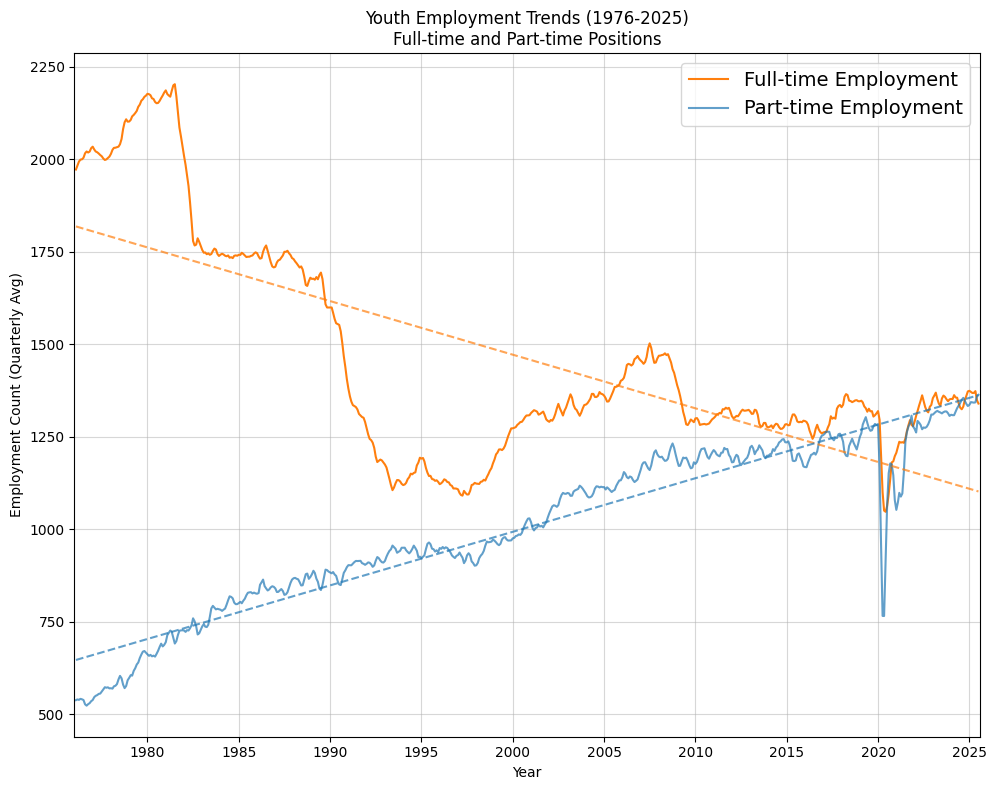

In [99]:
# Emplyment Trend (Full-time vs Part-time)

# Rolling averages
df_15to24_pivot["Full-time (smoothed)"] = (
    df_15to24_pivot["Full-time employment"].rolling(3, center=True).mean()
)
df_15to24_pivot["Part-time (smoothed)"] = (
    df_15to24_pivot["Part-time employment"].rolling(3, center=True).mean()
)

plt.figure(figsize=(10, 8))

# Smoothed lines
plt.plot(df_15to24_pivot.index, df_15to24_pivot["Full-time (smoothed)"], 
         color='tab:Orange', linewidth=1.5, label="Full-time Employment")
plt.plot(df_15to24_pivot.index, df_15to24_pivot["Part-time (smoothed)"], 
         color='tab:blue', linewidth=1.5, label="Part-time Employment", alpha = 0.7)

# Add linear trend lines
x = np.arange(len(df_15to24_pivot))

for col, c in [
    ("Full-time (smoothed)", "tab:Orange"),
    ("Part-time (smoothed)", "tab:blue")
]:
    y = df_15to24_pivot[col].values
    mask = ~np.isnan(y)  
    z = np.polyfit(x[mask], y[mask], 1)   
    p = np.poly1d(z)
    plt.plot(df_15to24_pivot.index[mask], p(x[mask]), 
             linestyle="--", linewidth=1.5, color=c, alpha=0.7)

# Formatting
plt.title("Youth Employment Trends (1976-2025)\nFull-time and Part-time Positions")
plt.xlabel("Year")
plt.ylabel("Employment Count (Quarterly Avg)")
plt.legend(fontsize = 14)
plt.grid(True, axis='both', alpha=0.5)
plt.tight_layout()
plt.xlim(df_15to24_pivot.index.min(), df_15to24_pivot.index.max())
plt.gca().xaxis.set_major_locator(mdates.YearLocator(5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.show()


### EDA 2) Interpretation - Youth Employment Trends (1976-2025)

The economy has undergone a structural shift:

- Full-time employment: declining or stagnating over the decades.
- Part-time employment: steadily growing, closing the gap.

This could reflect changes in labor market flexibility, gig economy rise, service-sector expansion, and shifts in employer preferences.

By 2025, the lines nearly intersect, showing part-time roles now make up almost the same volume as full-time.

# Analysis Questions

1) What is the trend of youth unemployment rate throught the years?

2) What are the Characteristics of Youth Unemployment in Duration?

## Q1) What is the trend of youth unemployment rate throught the years

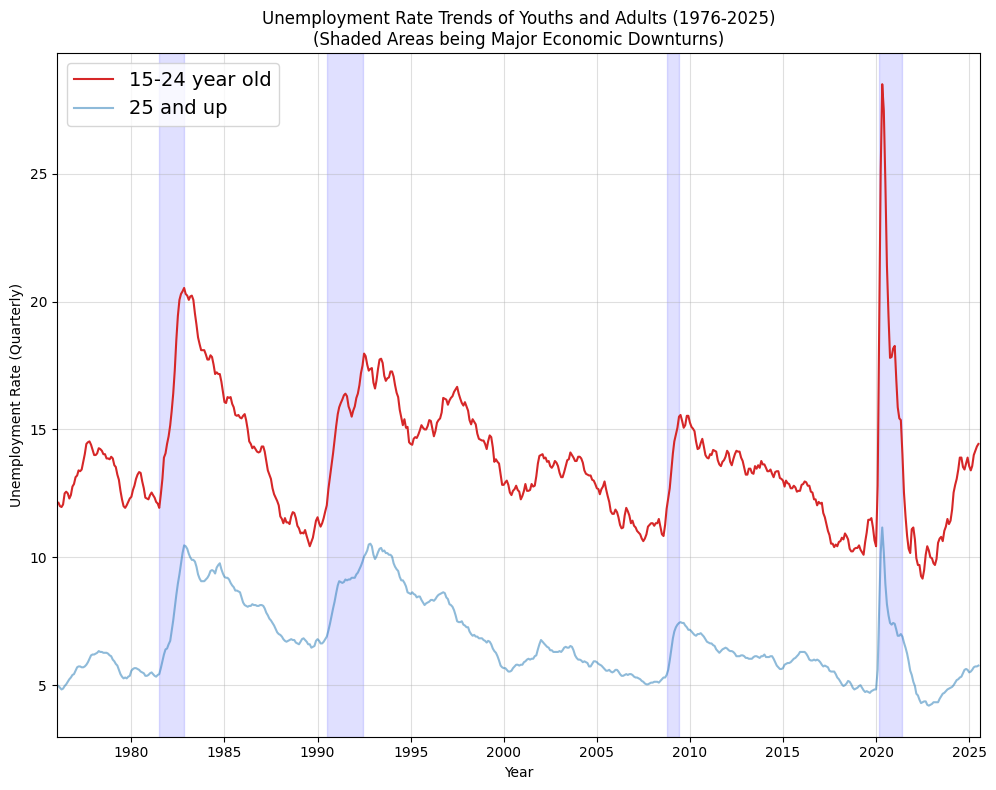

In [100]:
# Rolling averages
df_15to24_pivot["Unemployment rate (smoothed)"] = (
    df_15to24_pivot["Unemployment rate"].rolling(3, center=True).mean()
)
df_25up_pivot["Unemployment rate (smoothed)"] = (
    df_25up_pivot["Unemployment rate"].rolling(3, center=True).mean()
)

# Plot the unemployment rate time series
plt.figure(figsize=(10, 8))
plt.plot(df_15to24_pivot.index, df_15to24_pivot['Unemployment rate (smoothed)'], color='tab:red', linewidth=1.5, label = "15-24 year old")
plt.plot(df_25up_pivot.index, df_25up_pivot['Unemployment rate (smoothed)'], color='tab:blue', linewidth=1.5, label = "25 and up", alpha = 0.5)

# Shade major recession (date defined by wikipedia)
plt.axvspan('1981-07-01', '1982-11-01', color='blue', alpha=0.12)
plt.axvspan('1990-07-01', '1992-06-01', color='blue', alpha=0.12)
plt.axvspan('2008-10-01', '2009-06-01', color='blue', alpha=0.12)
plt.axvspan('2020-03-01', '2021-06-01', color='blue', alpha=0.12)

# Formatting
plt.title("Unemployment Rate Trends of Youths and Adults (1976-2025)\n(Shaded Areas being Major Economic Downturns)")
plt.xlabel("Year")
plt.ylabel("Unemployment Rate (Quarterly)")
plt.legend(loc = 'upper left', fontsize = 14)
plt.grid(True, axis='both', alpha=0.4)
plt.tight_layout()
plt.xlim(df_15to24_pivot.index.min(), df_15to24_pivot.index.max())
plt.gca().xaxis.set_major_locator(mdates.YearLocator(5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.show()

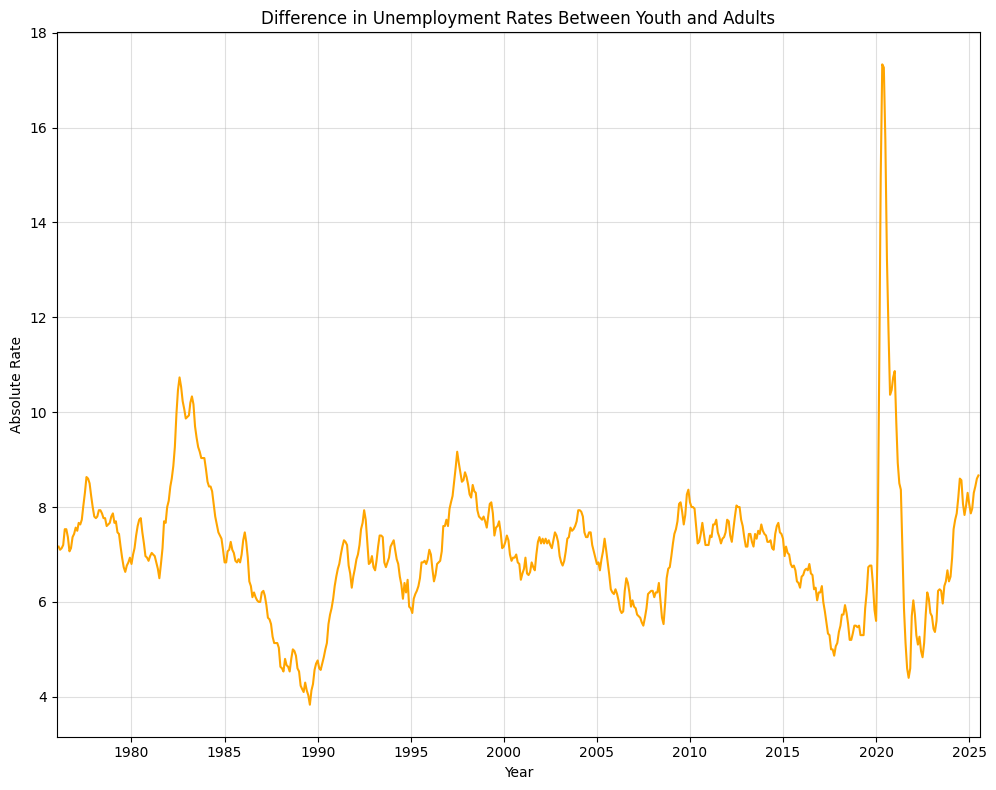

In [101]:
# Calculate the difference in unemployment rate between age groups
unemp_diff = abs(df_15to24_pivot['Unemployment rate (smoothed)'] - df_25up_pivot['Unemployment rate (smoothed)'])

plt.figure(figsize=(10,8))
plt.plot(unemp_diff, color = 'orange')

# Formatting
plt.title("Difference in Unemployment Rates Between Youth and Adults")
plt.xlabel("Year")
plt.ylabel("Absolute Rate")
plt.grid(True, axis='both', alpha=0.4)
plt.tight_layout()
plt.xlim(df_15to24_pivot.index.min(), df_15to24_pivot.index.max())
plt.gca().xaxis.set_major_locator(mdates.YearLocator(5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.show()

In [102]:
# Caalculate MAE
def cal_MAE(rate):
    y = rate.dropna()
    x = np.arange(len(y))
    
    # Fit a linear regression
    z = np.polyfit(x, y, 1)    # slope & intercept
    p = np.poly1d(z) 
    
    y_pred = p(x)
    
    # Calculate MAE
    mae = mean_absolute_error(y, y_pred)
    return mae
    
# Calling the method 
mae_15to24 =  cal_MAE(df_15to24_pivot["Unemployment rate"])
mae_25up = cal_MAE(df_25up_pivot["Unemployment rate"])

In [103]:
# Caculating the difference of unemployment rate between age groups 
unempRate_diff = abs(df_15to24_pivot['Unemployment rate'].mean() - df_25up_pivot['Unemployment rate'].mean())

print(f"Mean unemployment rate (15-24 year old): {df_15to24_pivot['Unemployment rate'].mean():.2f}% (mae: {mae_15to24:.2f})")
print(f"Mean unemployment rate (25 and up): {df_25up_pivot['Unemployment rate'].mean():.2f}% (mae: {mae_25up:.2f})")
print(f"Mean difference between youths and the general population: {unempRate_diff:.2f}%")

Mean unemployment rate (15-24 year old): 13.79% (mae: 1.79)
Mean unemployment rate (25 and up): 6.73% (mae: 1.11)
Mean difference between youths and the general population: 7.06%


### Q1 - Interpretations - Youth Unemployment Rate Trends (1976-2025)

- **Major economic downturns affect youths disproportionately**. While unemployment is sensitive to economic events, the rate of youth joblessness is much higher and more volatile than older cohorts 
    - 15-24 year old: 13.79% (mae: 1.79)
    - 25 year old and above: 6.73% (mae: 1.11)

- Labor force participation is cyclical: high in the late 80s, but collapsed in spring 2020 with lockdowns, then recovered.

## Q2 - What are the Characteristics of Youth Unemployment in Duration?

In [ ]:
# Read csv - Unemployment Duration (14100342)
 
# df_duration = pd.read_csv('data/14100342.csv') # Use with full dataset
df_duration = pd.read_csv('data/14100342_sample.csv')

In [105]:
# Preparing unemployment duration dataset for merge

# Preparing unemployment duration dataset for merge
rows2include_duration = (
    (df_duration['Age group'] == '15 to 24 years') &
    (df_duration['GEO'] == 'Canada') &
    (df_duration['Gender'] == 'Total - Gender') &
    (df_duration['Data type'] == 'Seasonally adjusted') &
    (df_duration['Statistics'] == 'Estimate')
)

df_duration_ = df_duration[rows2include_duration]

# Drop unused columns
col2drop = ['GEO', 'DGUID', 'Age group', 'Gender', 'Statistics', 'Data type', 'UOM', 'UOM_ID', 'SCALAR_FACTOR', 'SCALAR_ID', 'VECTOR', 'COORDINATE', 'STATUS', 'SYMBOL', 'TERMINATED', 'DECIMALS']

df_duration_filtered = df_duration_.drop(col2drop, axis=1)

In [106]:
# Defining durations to keep
durations = [
    '1 to 4 weeks',
    '5 to 13 weeks',
    '14 to 26 weeks',
    '27 weeks or more'
    ]

# Save a copy to csv for visualization
df_duration_viz = df_duration_filtered.copy()

# Change data type
df_duration_viz['REF_DATE'] = pd.to_datetime(df_duration_viz['REF_DATE'], format='%Y-%m')

# Set index
df_duration_viz.set_index('REF_DATE', inplace=True)

# filter rows where Duration of unemployment is in the list
df_duration_viz = df_duration_viz[
    df_duration_viz['Duration of unemployment'].isin(durations)
].copy()

# Inspect
print(df_duration_viz.head(10))

           Duration of unemployment  VALUE
REF_DATE                                  
1976-01-01             1 to 4 weeks  123.4
1976-01-01            5 to 13 weeks  115.3
1976-01-01           14 to 26 weeks   61.5
1976-01-01         27 weeks or more   38.0
1976-02-01             1 to 4 weeks  116.1
1976-02-01            5 to 13 weeks  114.9
1976-02-01           14 to 26 weeks   65.4
1976-02-01         27 weeks or more   41.8
1976-03-01             1 to 4 weeks  120.5
1976-03-01            5 to 13 weeks  117.0


In [107]:
# Pivot duration into features
def create_dura_col(df, durations):
    # pivot wider: rows = date, columns = duration, values = VALUE
    df_wide = df.pivot_table(
        index="REF_DATE", 
        columns="Duration of unemployment", 
        values="VALUE"
    )
    
    # keep only requested durations
    df_wide = df_wide[durations]
    
    # optional: tidy up
    df_wide = df_wide.sort_index().reset_index()

    return df_wide

# Create the columns
df_duration_cleaned = create_dura_col(df_duration_filtered, durations)

# Change data type
df_duration_cleaned['REF_DATE'] = pd.to_datetime(df_duration_cleaned['REF_DATE'], format='%Y-%m')

# Set index
df_duration_cleaned.set_index('REF_DATE', inplace=True)

df_duration_cleaned.head()

Duration of unemployment,1 to 4 weeks,5 to 13 weeks,14 to 26 weeks,27 weeks or more
REF_DATE,,,,
1976-01-01,123.4,115.3,61.5,38.0
1976-02-01,116.1,114.9,65.4,41.8
1976-03-01,120.5,117.0,60.6,34.5
1976-04-01,118.2,113.1,64.4,33.8
1976-05-01,115.9,112.2,68.5,37.2


In [108]:
# The average headcount in each unemployment duration
df_duration_cleaned.mean()

Duration of unemployment
1 to 4 weeks        161.502852
5 to 13 weeks       115.708725
14 to 26 weeks       58.679195
27 weeks or more     44.292282
dtype: float64

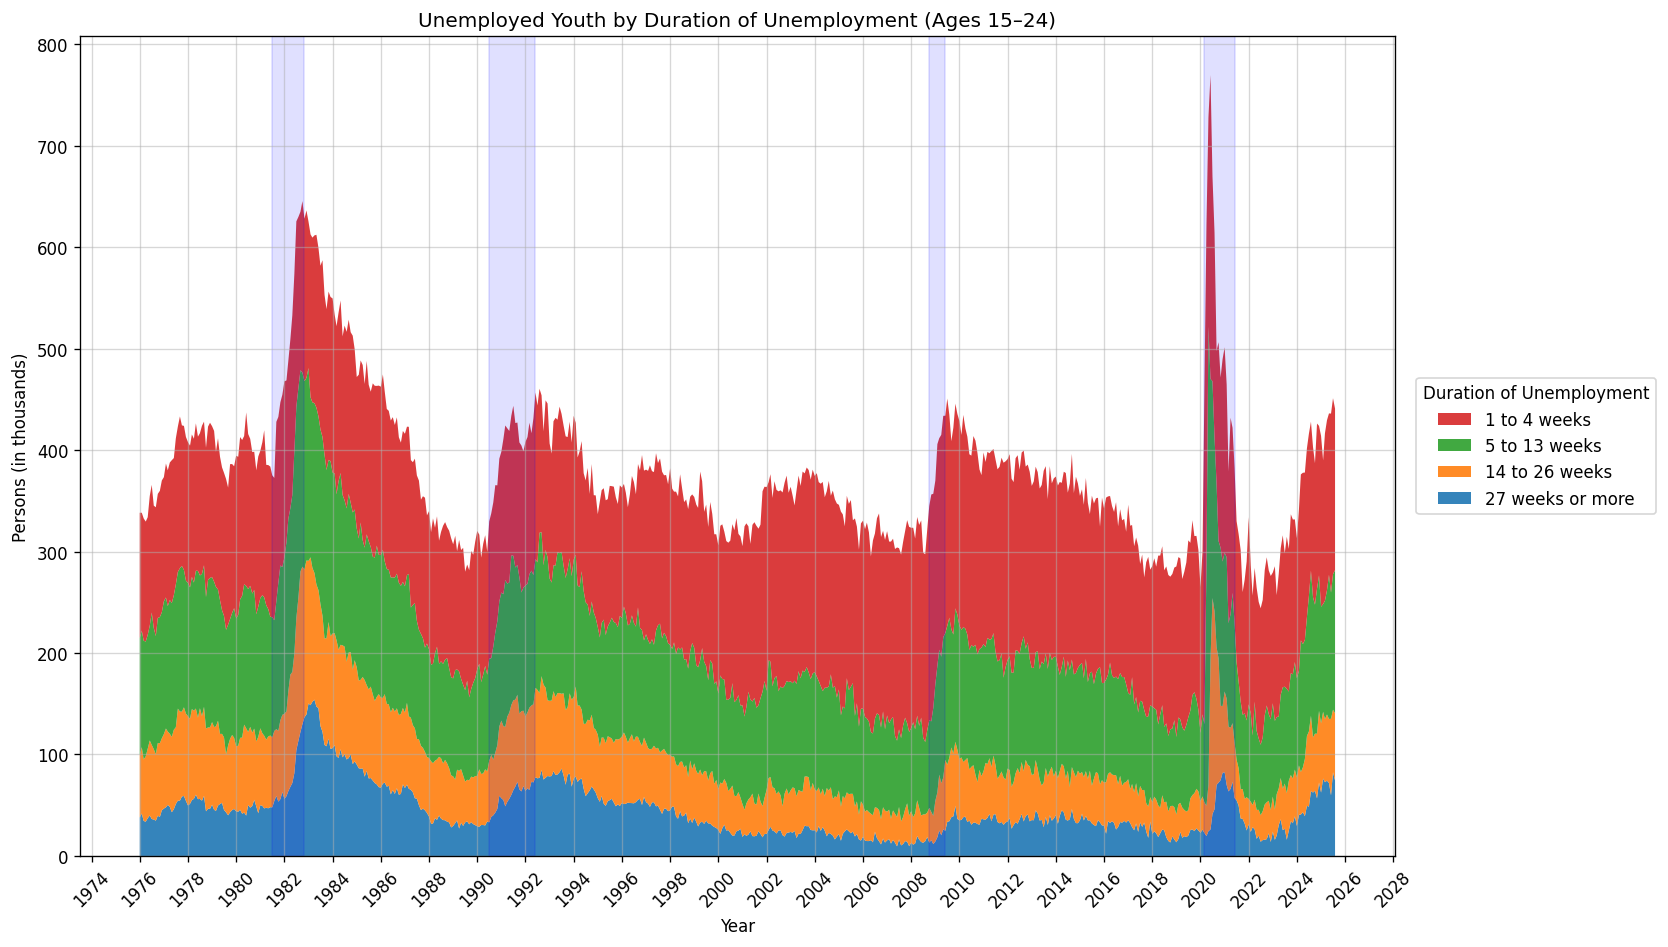

In [109]:
# Plot
fig, ax = plt.subplots(figsize=(14, 8), dpi=120)

# Order layers bottom → top (to resemble your screenshot)
order = ["27 weeks or more", "14 to 26 weeks", "5 to 13 weeks", "1 to 4 weeks"]

# Pivot to wide for stackplot
wide = (
    df_duration_viz
      .pivot_table(index="REF_DATE",
                   columns="Duration of unemployment",
                   values="VALUE",
                   aggfunc="sum")
      .reindex(columns=order)     # enforce desired layer order
      .sort_index()
      .fillna(0)
)

x = wide.index
ys = [wide[col].values for col in wide.columns]

stack = ax.stackplot(x, ys, labels=wide.columns, alpha=0.9)

# Shade major recession (date defined by wikipedia)
plt.axvspan('1981-07-01', '1982-11-01', color='blue', alpha=0.12)
plt.axvspan('1990-07-01', '1992-06-01', color='blue', alpha=0.12)
plt.axvspan('2008-10-01', '2009-06-01', color='blue', alpha=0.12)
plt.axvspan('2020-03-01', '2021-06-01', color='blue', alpha=0.12)

# Labels & styling
ax.set_title("Unemployed Youth by Duration of Unemployment (Ages 15–24)")
ax.set_xlabel("Year")
ax.set_ylabel("Persons (in thousands)")
ax.grid(True, alpha=0.5)

# Legend → reverse handles & labels
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title="Duration of Unemployment", 
          loc="center left", bbox_to_anchor=(1.01, 0.5))

# Year ticks
ax.xaxis.set_major_locator(mdates.YearLocator(base=2))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


## Q2) Interpretation - Unemployed Youth by Duration of Unemployment (Ages 15–24)

1) **Short-term unemployment dominates**

    The largest share of unemployed youths is almost always in the “1 to 4 weeks” category (red).

    - This shows that youth unemployment is usually brief and transitional — many quickly find jobs or re-enter school/training.

2) **Economic downturns = spikes in both incidence and duration**

    During recessions, total unemployment rises (the chart gets taller).

    - The share of longer unemployment durations also expands — meaning not only more youths are unemployed, but they stay unemployed for longer.

3) **Long-term unemployment (27+ weeks)**

    While always the smallest group, it increase visibly in downturns.
    
    - Shows that recessions leave a lasting scar for some youths, who struggle to re-enter the job market even after recovery begins.

In [110]:
# Write to csv
df_15to24_pivot.to_csv('productivity_cleaned.csv')
df_duration_cleaned.to_csv('duration_cleaned.csv')
